# Analyzing Fuel Price Data
- Exploring the fuel price dataset (link below)

# Data
- [Link to Fuel Data](https://www.bls.gov/developers/home.htm)

# Import Dependencies

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import pickle

In [2]:
# Mount google drive and save this model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper Functions

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Helper function to plot our time series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(False)

def moving_avg(array: list, window_length: int) -> list:
    """Calculates rolling mean of length window_lenght of an array of integers"""
    moving_avg_list = []
    start_idx_window = 0
    end_idx_window = window_length

    while end_idx_window < len(array):
        current_values = array[start_idx_window: end_idx_window]
        current_mean = sum(current_values) / window_length
        moving_avg_list.append(current_mean)
        start_idx_window += 1
        end_idx_window += 1

    return moving_avg_list

def calc_mae(y: list, y_pred: list) -> float:
    """Calculates and returns mae for series y values and predicted values"""
    n = len(y_pred)
    len_diff = len(y) - len(y_pred)
    y = y[len_diff: ]
    currentSum = 0
    for i in range(len(y)):
        currentSum += abs(y[i] - y_pred[i])
    mae = currentSum / n
    return mae

# Data Pipeline

In [4]:
# Iterate through BLS API (limits 20 years per request) at a time
# Start with 1976
# increment until current year (2022)
# 500 daily call limit

class GasPipeline:
    def __init__(self, year_start = 1976, api_key = "7e2ef7c028774d9db144d3f1c78b1023", url = "https://api.bls.gov/publicAPI/v2/timeseries/data/", data_dict = {"period": [], "periodName": [], "value": [], "year": [], "date": []}):
        self.api_key = api_key
        self.url = url
        self.year_start = year_start
        self.data_dict = data_dict

    def get_raw_data(self):

        while self.year_start <= 2023:

            payload = {
                "seriesid": "APU000074714", # series Id
                "registrationkey": self.api_key,
                "startyear": "{}".format(self.year_start),
                "endyear": "{}".format(self.year_start + 1)
                }

            response = requests.post(url=self.url, data=payload)
            raw_data = response.json()
            raw_data = raw_data["Results"]["series"][0]["data"]

            for element in raw_data:
                for item in element:
                    if item != "latest" and item != "footnotes":
                        if item == "value":
                            self.data_dict[item].append(float(element[item]))
                        else:
                            self.data_dict[item].append(element[item])
                    else:
                        continue 

            self.year_start += 2

        return self.data_dict

    def create_date_column(self):
        for (i, j) in zip(self.data_dict["periodName"], self.data_dict["year"]):
            date_formatted = parser.parse(i + " " + "1" + " " + j)
            self.data_dict["date"].append(date_formatted)

    def save_pickle(self, data_dict_filename = "/content/drive/MyDrive/Colab Notebooks/fuel/fuel_prices.p"):
        pickle.dump(self.data_dict, open(data_dict_filename, "wb"))

    def load_pickle(self, data_dict_filename = "/content/drive/MyDrive/Colab Notebooks/fuel/fuel_prices.p"):
        return pickle.load(open(data_dict_filename, "rb"))


In [ ]:
# Run pipeline
# etl = GasPipeline()
# data_dict = etl.get_raw_data()
# etl.create_date_column()
# etl.save_pickle()

In [6]:
# Load data
etl = GasPipeline()
data_dict = etl.load_pickle()
df = pd.DataFrame(data=data_dict)
df.sort_values(by=["year", "period"], axis=0, ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df['price_change'] = df['value'].diff()
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   period        558 non-null    object        
 1   periodName    558 non-null    object        
 2   value         558 non-null    float64       
 3   year          558 non-null    object        
 4   date          558 non-null    datetime64[ns]
 5   price_change  558 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 26.3+ KB


The dataset looks relatively clean. No null values, and the data types are right. Let's take a deeper look

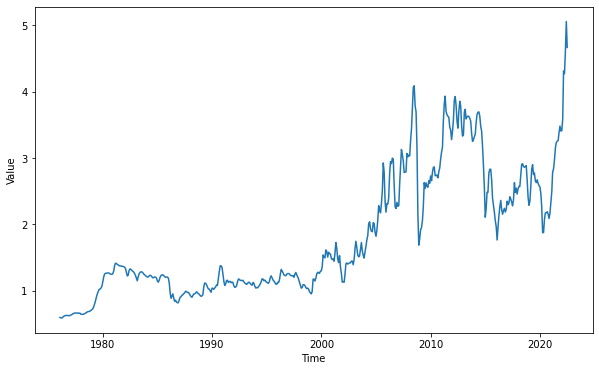

In [9]:
@dataclass
class G:
    TIME, SERIES = df.date.values, df.value.values
    SPLIT_TIME = int(round(len(df) * .8, 0)) # 80% of the data is training data
    WINDOW_SIZE = 20 # how many data points will we take into account to make our prediction
    BATCH_SIZE = 5 # how many examples will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000 # we need this parameter to define the Tensorflow sample buffer

# Plot the series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show;

Let's look at the moving averages using several window sizes

In [10]:
three_month_ma = moving_avg(array = G.SERIES, window_length = 3)
six_month_ma = moving_avg(array = G.SERIES, window_length = 6)
nine_month_ma = moving_avg(array = G.SERIES, window_length = 9)
twelve_month_ma = moving_avg(array = G.SERIES, window_length = 12)

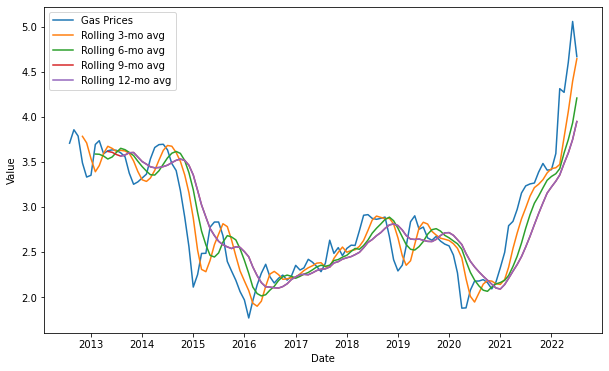

In [21]:
# Plot the series with the rolling averages
idx_slicer = 120
plt.figure(figsize=(10, 6))
plt.plot(G.TIME[-idx_slicer: ], G.SERIES[-idx_slicer: ], label="Gas Prices")
plt.plot(G.TIME[-idx_slicer + 3: ], three_month_ma[-idx_slicer + 3: ], label = 'Rolling 3-mo avg')
plt.plot(G.TIME[-idx_slicer + 6: ], six_month_ma[-idx_slicer + 6: ], label = 'Rolling 6-mo avg')
plt.plot(G.TIME[-idx_slicer + 9: ], nine_month_ma[-idx_slicer + 9: ], label = 'Rolling 9-mo avg')
plt.plot(G.TIME[-idx_slicer + 12: ], nine_month_ma[-idx_slicer + 12: ], label = 'Rolling 12-mo avg')
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show();